In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('fivethirtyeight')

# Manual step: go download latest version of air quality data
1. Go to <a href="https://aqicn.org/data-platform/register/" target="_blank">AQIcn.org</a>
2. Scroll to "Free downloadable database"
3. Enter Wuhan and search
4. Scroll down and click the button under "Wuhan past 75 months daily average AQI"
5. Enter your details, agree to the EULA, and click Submit

In [2]:
# Download data: https://aqicn.org/data-platform/register/
df = pd.read_csv('data/wuhan-air-quality_20200319.csv', sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')

# Convert to datetime
df['date'] =  pd.to_datetime(df['date'], format='%Y/%m/%d')

df = df.set_index('date')

# We care only about NO2 values by date
# https://earthobservatory.nasa.gov/images/146362/airborne-nitrogen-dioxide-plummets-over-china
# "The maps on this page show concentrations of nitrogen dioxide, a noxious gas emitted by motor vehicles, power plants, and industrial facilities. The maps above show NO2 values across China from January 1-20, 2020 (before the quarantine) and February 10-25 (during the quarantine)."
df = df.drop(df.columns[[0, 1, 2, 4, 5]], axis=1)

# Convert from multindex to columns
df.reset_index(inplace=True)  

print(df.shape)
print(df.dtypes)

# List columns, # of rows w non-null in each column, column data types 
df.info()
df.describe()

df.head()

(2145, 2)
date    datetime64[ns]
no2            float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145 entries, 0 to 2144
Data columns (total 2 columns):
date    2145 non-null datetime64[ns]
no2     2120 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.6 KB


,date,no2
0,2020-03-02,10.0
1,2020-03-03,10.0
2,2020-03-04,15.0
3,2020-03-05,15.0
4,2020-03-06,12.0


In [4]:
# Do the column names actually have spaces in front of the name? Had that once...
print(df.columns.tolist())

df.index.names
df.nsmallest(5, "no2") 
df.nlargest(5, "no2")

['date', 'no2']


,date,no2
1599,2015-04-23,81.0
1677,2015-01-10,78.0
1678,2015-01-11,77.0
1631,2015-05-25,74.0
1983,2014-05-16,74.0


# Feature Engineering - add metadata

In [6]:
# Add year 
df['Year'] = pd.DatetimeIndex(df['date']).year

# Add feature for YYYY-MM
df['Month'] = df['date'].dt.to_period('M')
df['MonthName'] = df['date'].dt.strftime('%b')
df['MonthYear'] = df['date'].dt.strftime('%Y-%b')

# Add feature for week 
df['Week'] = df['date'].dt.to_period(freq = 'W')  

df['c'] = df['date'].dt.dayofyear 
df['DayOfWeek'] = df['date'].dt.dayofweek # 0 = Sunday 
df['Day'] = df['date'].dt.day_name()
df['_IsWeekend'] = np.where(df['Day'].isin(['Saturday', 'Sunday']), 1, 0) # Add a boolean column 

df = df.sort_values(['Year', 'DayOfYear'])
df.head()

,date,no2,Year,Month,MonthName,MonthYear,Week,DayOfYear,DayOfWeek,Day,_IsWeekend
2144,2014-01-01,69.0,2014,2014-01,Jan,2014-Jan,2013-12-30/2014-01-05,1,2,Wednesday,0
2030,2014-01-02,70.0,2014,2014-01,Jan,2014-Jan,2013-12-30/2014-01-05,2,3,Thursday,0
2031,2014-01-03,52.0,2014,2014-01,Jan,2014-Jan,2013-12-30/2014-01-05,3,4,Friday,0
2032,2014-01-04,50.0,2014,2014-01,Jan,2014-Jan,2013-12-30/2014-01-05,4,5,Saturday,1
2033,2014-01-05,59.0,2014,2014-01,Jan,2014-Jan,2013-12-30/2014-01-05,5,6,Sunday,1


# Look at the past 30 days only

In [9]:
day_of_year = datetime.now().timetuple().tm_yday
print(f'Today is the {day_of_year} day of 2020')

Today is the 79 day of 2020


In [13]:
df1 = df[(df["DayOfYear"] >= (day_of_year - 30)) & (df["DayOfYear"] < day_of_year)]

print(f'   ... looking at dates for day of year {day_of_year - 30} - {day_of_year}')

# Alternate:
months = ['Mar']
x = df.query("MonthName in @months")
x.head()

   ... looking at dates for day of year 49 - 79


,date,no2,Year,Month,MonthName,MonthYear,Week,DayOfYear,DayOfWeek,Day,_IsWeekend
2088,2014-03-01,19.0,2014,2014-03,Mar,2014-Mar,2014-02-24/2014-03-02,60,5,Saturday,1
2089,2014-03-02,26.0,2014,2014-03,Mar,2014-Mar,2014-02-24/2014-03-02,61,6,Sunday,1
2090,2014-03-03,34.0,2014,2014-03,Mar,2014-Mar,2014-03-03/2014-03-09,62,0,Monday,0
2091,2014-03-04,39.0,2014,2014-03,Mar,2014-Mar,2014-03-03/2014-03-09,63,1,Tuesday,0
2092,2014-03-05,37.0,2014,2014-03,Mar,2014-Mar,2014-03-03/2014-03-09,64,2,Wednesday,0


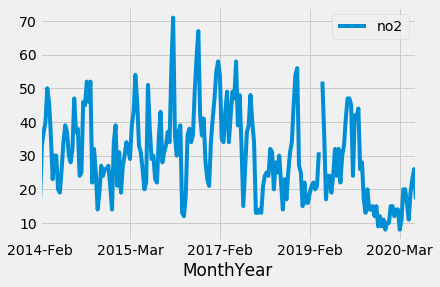

In [18]:
df1.plot(
    x='MonthYear'
    , y='no2'
)

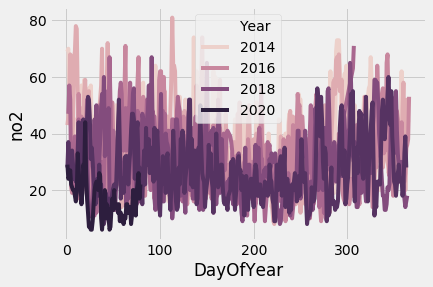

In [24]:
sns.lineplot(
    x="DayOfYear"
    , y="no2"
    , hue="Year"
    , ci = None # turn off error bars
    , data=df
)

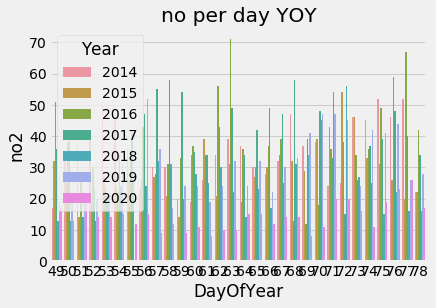

In [21]:
sns.barplot(
    x="DayOfYear"
    , y="no2"
    , hue="Year"
    , data=df1
)
plt.title("no per day YOY")
plt.show()

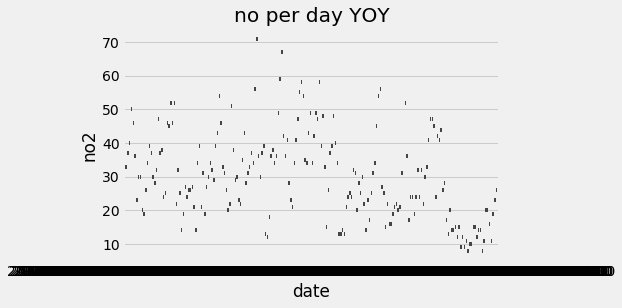

In [25]:
sns.boxplot(x="date", y="no2", data=df1)
plt.title("no per day YOY")
plt.show()

ValueError: Invalid RGBA argument: masked

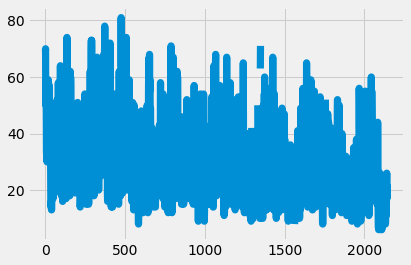

In [26]:
sns.pointplot(x="date", y="no2", data=df)
plt.title("Confirmed Cases per Day")
plt.show()

In [ ]:
# pip install plotly_express
import plotly.express as px
px.line(
    df1
    , x='DayOfYear'
    , y= 'no2'
    , color = 'Year'
)